# Analyse Exploratoire du Dataset Chicago Taxi Trips (Version Améliorée V3)

 Ce notebook vise à explorer en profondeur un échantillon du dataset Chicago Taxi Trips. Nous allons :
 - Charger et nettoyer initialement les données.
 - Effectuer des vérifications de qualité approfondies : valeurs manquantes, incohérences, valeurs nulles/faibles, outliers (via IQR).
 - Analyser en détail les cas de courses à faible valeur (distance, durée, tarif).
 - Explorer la distribution des variables clés et leurs transformations (log, clipping IQR).
 - Analyser les interactions entre variables numériques et catégorielles.
 - Créer et analyser des features temporelles et la vitesse moyenne.
 - Tirer des conclusions précises et définir des prochaines étapes claires pour le prétraitement et la modélisation, en tenant compte des spécificités et limitations de cet échantillon.

In [1]:
# Import des librairies nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno  # pour visualiser les valeurs manquantes

# Configuration d'affichage
%matplotlib inline
sns.set(style="whitegrid", context="talk")  # style épuré et taille adaptée aux présentations
# Définir une palette de couleurs réutilisable
base_palette = sns.color_palette("viridis", 8)
sns.set_palette(base_palette)

# Supprimer les warnings pour une sortie plus propre (optionnel)
import warnings
warnings.filterwarnings('ignore')

## 1. Chargement et Nettoyage Initial
 Chargement, nettoyage des noms de colonnes, aperçu initial et conversion des types de base.

In [2]:
# Installer pandas-gbq (si nécessaire)
# !pip install pandas-gbq --quiet

import pandas as pd

# Définir les paramètres d'accès BigQuery
project_id = "avisia-certification-ml-yde"  # Remplace par ton ID projet GCP

# Définition de la requête SQL pour récupérer un échantillon depuis BigQuery
query = """
SELECT *
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE trip_start_timestamp BETWEEN '2023-01-01' AND '2023-01-07'
LIMIT 100000
"""

# Chargement du dataset depuis BigQuery
try:
    df = pd.read_gbq(query, project_id=project_id)
    print("Dataset chargé avec succès depuis BigQuery.")
except Exception as e:
    print(f"Erreur lors du chargement depuis BigQuery: {e}")
    exit()

# Nettoyage initial des noms de colonnes
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
print("\nNoms des colonnes après nettoyage :")
print(df.columns)

# Conversion initiale des types (Timestamps et Numériques clés)
print("\nConversion initiale des types...")
# Timestamps
for col in ['trip_start_timestamp', 'trip_end_timestamp']:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
    else:
        print(f"Colonne timestamp '{col}' non trouvée.")

# Numériques clés
cols_numeric = ['trip_seconds', 'trip_miles', 'fare', 'tips', 'tolls', 'extras', 'trip_total']
for col in cols_numeric:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    else:
        print(f"Colonne numérique '{col}' non trouvée.")

print("Conversion initiale des types terminée.")

# Afficher infos, aperçu et describe complet
print("\nInformations générales sur le DataFrame (après conversions initiales):")
df.info()
print("\nAperçu des données (5 premières lignes) :")
print(df.head())
print("\nStatistiques descriptives complètes (avant nettoyage approfondi) :")
print(df.describe(include='all'))


Dataset chargé avec succès depuis BigQuery.

Noms des colonnes après nettoyage :
Index(['unique_key', 'taxi_id', 'trip_start_timestamp', 'trip_end_timestamp',
       'trip_seconds', 'trip_miles', 'pickup_census_tract',
       'dropoff_census_tract', 'pickup_community_area',
       'dropoff_community_area', 'fare', 'tips', 'tolls', 'extras',
       'trip_total', 'payment_type', 'company', 'pickup_latitude',
       'pickup_longitude', 'pickup_location', 'dropoff_latitude',
       'dropoff_longitude', 'dropoff_location'],
      dtype='object')

Conversion initiale des types...
Conversion initiale des types terminée.

Informations générales sur le DataFrame (après conversions initiales):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73747 entries, 0 to 73746
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   unique_key              73747 non-null  object             
 1 

## 2. Analyse Approfondie de la Qualité des Données
 Investigation des valeurs manquantes, des incohérences et des valeurs potentiellement erronées (nulles, faibles, extrêmes).

### 2.1 Analyse des Valeurs Manquantes


Pourcentage de valeurs manquantes par colonne (> 0%):
dropoff_census_tract      72.691771
pickup_census_tract       72.214463
dropoff_community_area    10.496698
dropoff_location          10.205161
dropoff_longitude         10.205161
dropoff_latitude          10.205161
pickup_community_area      6.381277
pickup_latitude            6.370429
pickup_longitude           6.370429
pickup_location            6.370429
extras                     0.098987
fare                       0.098987
tips                       0.098987
trip_total                 0.098987
tolls                      0.098987
trip_seconds               0.037968
trip_end_timestamp         0.010848
dtype: float64

Visualisation de la Matrice des Valeurs Manquantes:


<Figure size 1600x800 with 0 Axes>

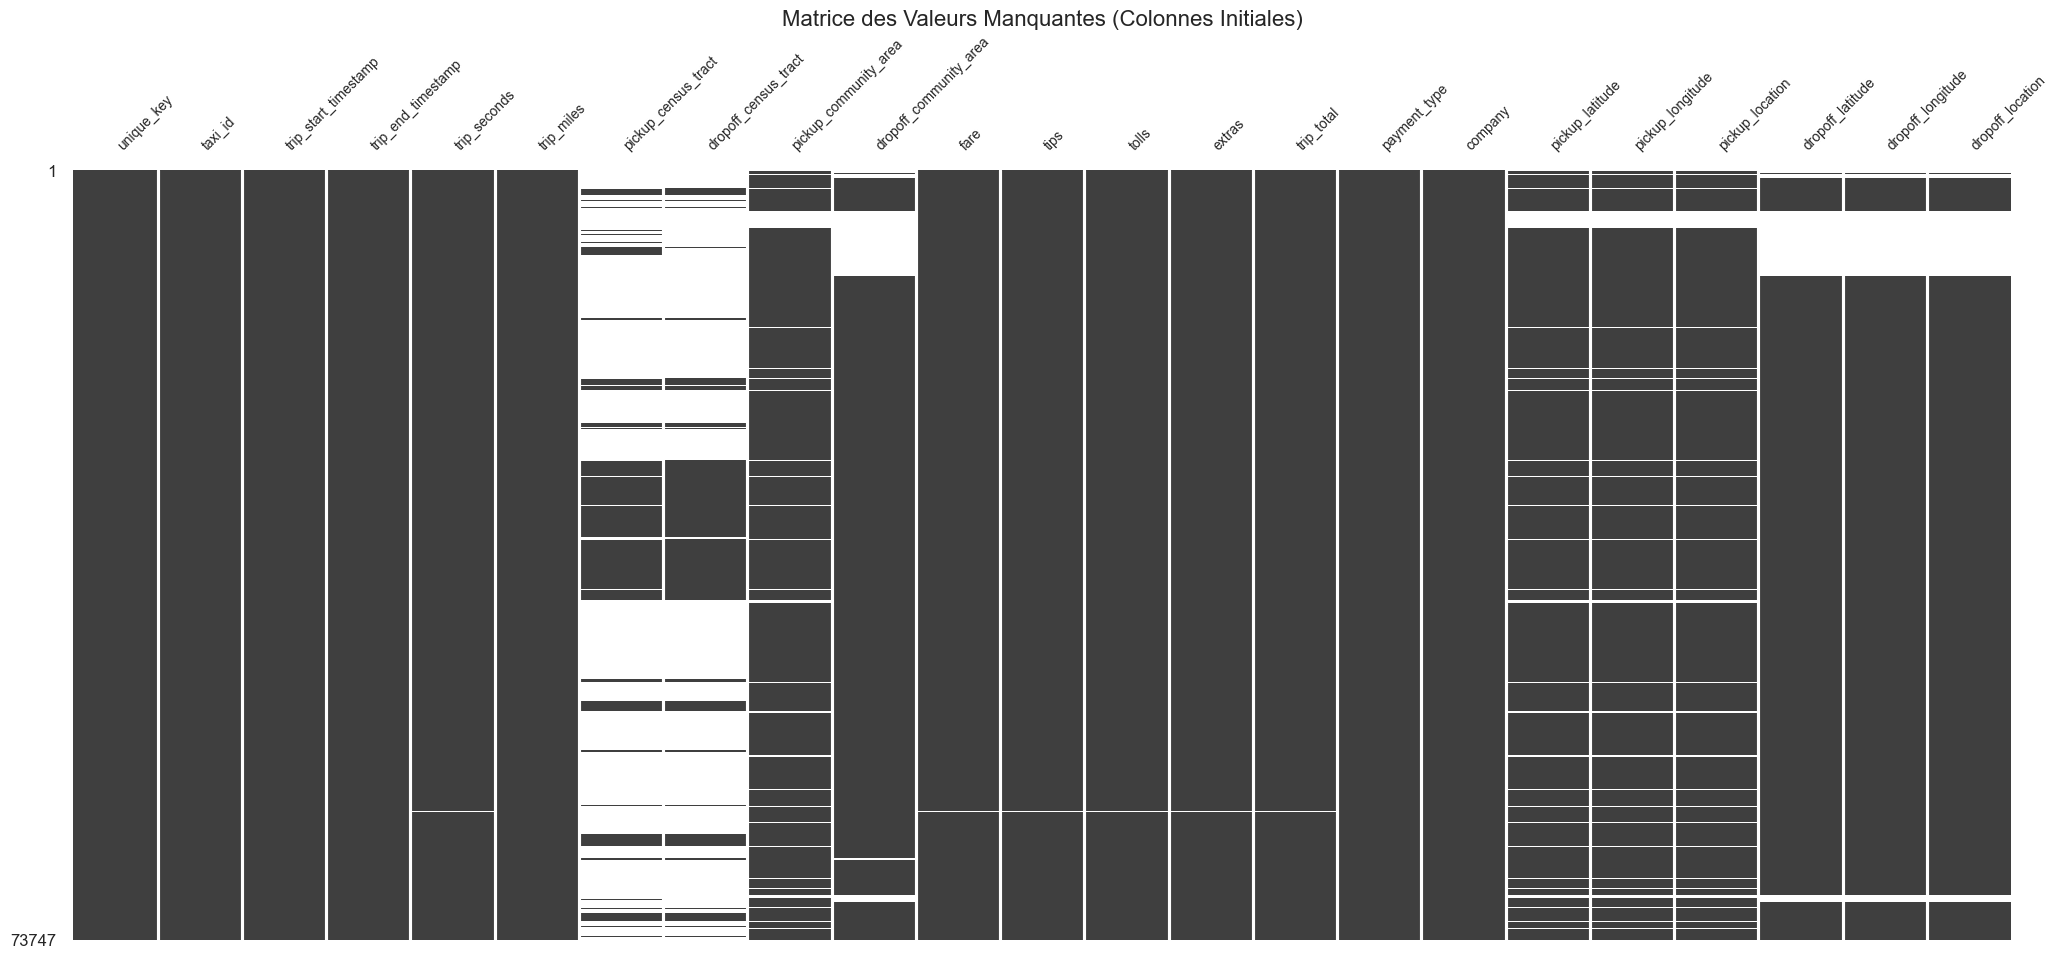


Visualisation du Pourcentage de Valeurs Manquantes:


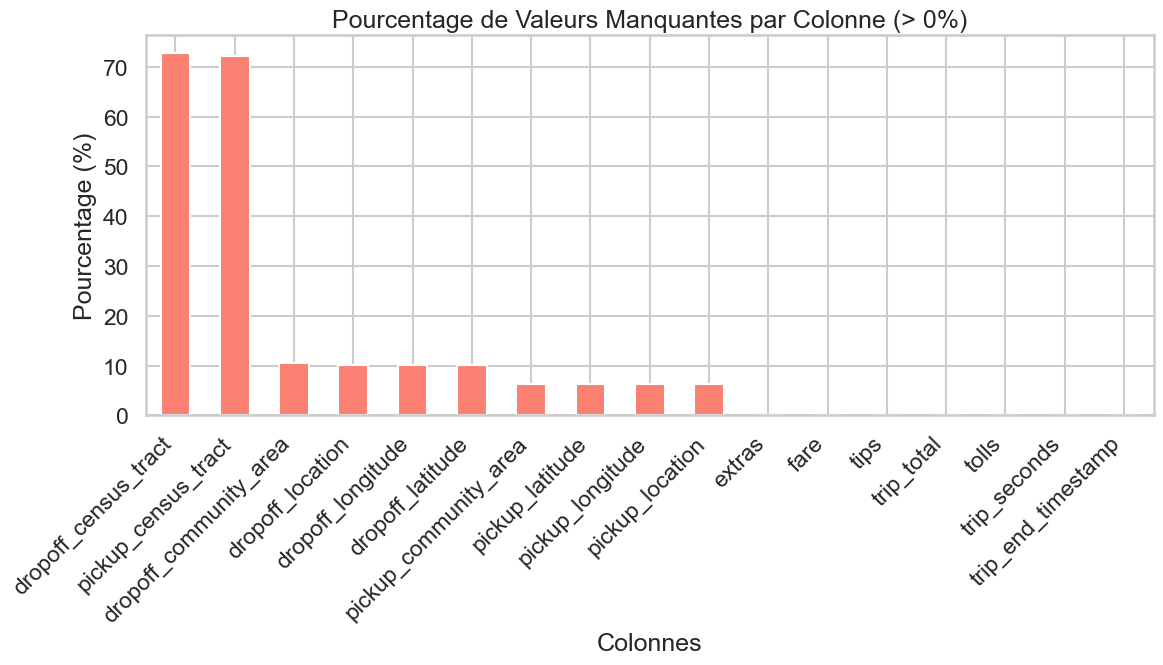

In [3]:
# Calcul et tri des pourcentages de valeurs manquantes
missing_pct = df.isnull().sum() / len(df) * 100
missing_pct = missing_pct[missing_pct > 0].sort_values(ascending=False)
print("\nPourcentage de valeurs manquantes par colonne (> 0%):")
print(missing_pct)

# Visualisation du pattern des valeurs manquantes avec missingno
print("\nVisualisation de la Matrice des Valeurs Manquantes:")
plt.figure(figsize=(16, 8))
msno.matrix(df.iloc[:, :40], sparkline=False, fontsize=10) # Ajuster le nombre de colonnes si nécessaire
plt.title("Matrice des Valeurs Manquantes (Colonnes Initiales)", fontsize=16)
plt.show()

# Visualisation par barre
print("\nVisualisation du Pourcentage de Valeurs Manquantes:")
plt.figure(figsize=(12, 7))
missing_pct.plot(kind='bar', color='salmon')
plt.title("Pourcentage de Valeurs Manquantes par Colonne (> 0%)")
plt.ylabel("Pourcentage (%)")
plt.xlabel("Colonnes")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Constat Valeurs Manquantes :** Le problème est sévère pour les données de localisation (`pickup/dropoff_*`) et `company` dans cet *échantillon*. Toute analyse ou feature basée sur la localisation géographique sera impossible ou très peu fiable avec ces données. Les autres colonnes ont un taux de manquants plus gérable (< 20% pour `tolls`, < 2% pour `trip_seconds`, `fare`, etc.).

### 2.2 Analyse des Valeurs Nulles et Très Faibles
 Ces valeurs sont fréquentes dans l'échantillon et nécessitent une attention particulière.

In [4]:
# Création de 'trip_minutes' pour analyse (si 'trip_seconds' existe)
if 'trip_seconds' in df.columns:
    df['trip_minutes'] = df['trip_seconds'] / 60

# Analyse des courses avec durée <= 0
print("\nAnalyse des courses avec durée <= 0 minute(s):")
zero_duration_trips = df[df['trip_minutes'] <= 0] if 'trip_minutes' in df.columns else pd.DataFrame()
count_zero_duration = len(zero_duration_trips)
print(f"Nombre de courses avec durée <= 0 : {count_zero_duration}")
if count_zero_duration > 0:
    print("Caractéristiques (médianes) de ces courses:")
    # Afficher médianes pour éviter l'effet d'outliers potentiels au sein de ce sous-groupe
    print(zero_duration_trips[['trip_minutes', 'trip_miles', 'fare', 'trip_total']].median())
    print("Types de paiement les plus fréquents pour durée <= 0:")
    if 'payment_type' in zero_duration_trips.columns:
        print(zero_duration_trips['payment_type'].value_counts().head())

# Analyse des courses avec distance <= 0
print("\nAnalyse des courses avec distance <= 0 mile(s):")
zero_distance_trips = df[df['trip_miles'] <= 0] if 'trip_miles' in df.columns else pd.DataFrame()
count_zero_distance = len(zero_distance_trips)
print(f"Nombre de courses avec distance <= 0 : {count_zero_distance}")
if count_zero_distance > 0:
    print("Caractéristiques (médianes) de ces courses:")
    print(zero_distance_trips[['trip_minutes', 'trip_miles', 'fare', 'trip_total']].median())
    print("Types de paiement les plus fréquents pour distance <= 0:")
    if 'payment_type' in zero_distance_trips.columns:
        print(zero_distance_trips['payment_type'].value_counts().head())

# Analyse des courses avec tarif <= 0
print("\nAnalyse des courses avec tarif <= 0:")
zero_fare_trips = df[df['fare'] <= 0] if 'fare' in df.columns else pd.DataFrame()
count_zero_fare = len(zero_fare_trips)
print(f"Nombre de courses avec tarif <= 0 : {count_zero_fare}")
if count_zero_fare > 0:
    print("Caractéristiques (médianes) de ces courses:")
    print(zero_fare_trips[['trip_minutes', 'trip_miles', 'fare', 'tips', 'trip_total']].median())
    print("Types de paiement les plus fréquents pour tarif <= 0:")
    if 'payment_type' in zero_fare_trips.columns:
        print(zero_fare_trips['payment_type'].value_counts().head())
    # Vérifier si trip_total est aussi nul quand fare est nul
    if 'trip_total' in zero_fare_trips.columns:
        print(f"Pourcentage de ces courses où trip_total > 0 : {100 * (zero_fare_trips['trip_total'] > 0).mean():.2f}%")

# Analyse des courses avec très faible distance (>0 mais < 0.1 miles)
print("\nAnalyse des courses avec très faible distance (0 < miles < 0.1):")
very_low_distance = df[(df['trip_miles'] > 0) & (df['trip_miles'] < 0.1)] if 'trip_miles' in df.columns else pd.DataFrame()
count_vlow_dist = len(very_low_distance)
print(f"Nombre de courses : {count_vlow_dist}")
if count_vlow_dist > 0:
     print("Caractéristiques (médianes):")
     print(very_low_distance[['trip_minutes', 'trip_miles', 'fare', 'trip_total']].median())


Analyse des courses avec durée <= 0 minute(s):
Nombre de courses avec durée <= 0 : 1420
Caractéristiques (médianes) de ces courses:
trip_minutes     0.0
trip_miles       0.0
fare            3.25
trip_total      3.25
dtype: Float64
Types de paiement les plus fréquents pour durée <= 0:
payment_type
Cash           1153
Credit Card     253
Dispute           6
Unknown           4
No Charge         3
Name: count, dtype: int64

Analyse des courses avec distance <= 0 mile(s):
Nombre de courses avec distance <= 0 : 7792
Caractéristiques (médianes) de ces courses:
trip_minutes      5.0
trip_miles        0.0
fare             7.75
trip_total      10.25
dtype: Float64
Types de paiement les plus fréquents pour distance <= 0:
payment_type
Cash           3725
Mobile         1822
Credit Card    1771
Unknown         439
Prcard           21
Name: count, dtype: int64

Analyse des courses avec tarif <= 0:
Nombre de courses avec tarif <= 0 : 37
Caractéristiques (médianes) de ces courses:
trip_minutes    4.

**Constat Valeurs Nulles/Faibles :** Une proportion *très significative* des courses dans cet échantillon présente une durée, une distance et/ou un tarif nul(le) ou extrêmement faible.
 - Les courses à durée/distance nulle ont souvent aussi un tarif nul.
 - Les courses à tarif nul n'ont pas toujours un `trip_total` nul (pourboires/extras possibles ?).
 - Les types de paiement associés varient, mais "No Charge" ou "Dispute" pourraient être surreprésentés (à vérifier sur le dataset complet).
 - La présence massive de ces cas suggère soit un problème systématique dans la collecte/export des données *de cet échantillon*, soit qu'il contient beaucoup de trajets non standards (annulés, refusés, tests, etc.). **Une stratégie de filtrage agressive de ces lignes semble nécessaire pour une modélisation standard du tarif.**

### 2.3 Vérification des Incohérences

#### 2.3.1 Incohérence des Totaux Monétaires

In [5]:
# Calcul de la différence (déjà fait si les colonnes existent)
if 'total_difference' in df.columns:
    print("\nAnalyse de l'incohérence des totaux (trip_total vs somme composantes):")
    print(df['total_difference'].describe())
    significant_diff_total = df[abs(df['total_difference']) > 0.01] # Seuil de $0.01
    print(f"Nombre de lignes avec différence > $0.01 : {len(significant_diff_total)}")
    if not significant_diff_total.empty:
        print("Top 5 des différences absolues les plus grandes:")
        # Afficher les lignes avec la plus grande différence absolue
        diff_sorted = df.loc[df['total_difference'].abs().sort_values(ascending=False).index]
        cols_to_show = [c for c in ['fare', 'tips', 'tolls', 'extras', 'trip_total', 'calculated_total', 'total_difference'] if c in df.columns]
        print(diff_sorted[cols_to_show].head())
else:
    print("\nCalcul de 'total_difference' non effectué précédemment.")


Calcul de 'total_difference' non effectué précédemment.


#### 2.3.2 Incohérence de la Durée

In [6]:
# Analyse de la différence (déjà fait si les colonnes existent)
if 'duration_difference' in df.columns:
    print("\nAnalyse de l'incohérence de la durée (trip_seconds vs timestamps):")
    print(df['duration_difference'].dropna().describe())
    significant_diff_duration = df[abs(df['duration_difference'].fillna(0)) > 60] # Seuil de 60s
    print(f"Nombre de lignes avec différence > 60s : {len(significant_diff_duration)}")
    if not significant_diff_duration.empty:
        print("Top 5 des différences absolues les plus grandes:")
        diff_sorted_dur = df.loc[df['duration_difference'].abs().sort_values(ascending=False).index]
        cols_to_show_dur = [c for c in ['trip_start_timestamp', 'trip_end_timestamp', 'trip_seconds', 'duration_calculated', 'duration_difference'] if c in df.columns]
        print(diff_sorted_dur[cols_to_show_dur].head())

    # Vérifier à nouveau les fins avant début
    invalid_time_order = df[df['trip_end_timestamp'] <= df['trip_start_timestamp']]
    print(f"\nNombre de courses terminant avant ou au même moment que le début : {len(invalid_time_order)}")

else:
    print("\nCalcul de 'duration_difference' non effectué précédemment.")


Calcul de 'duration_difference' non effectué précédemment.


**Constat Incohérences :** Bien que la plupart des courses soient cohérentes, un certain nombre présentent des écarts significatifs pour les totaux et les durées. Les écarts de durée pourraient être dus à des arrondis différents entre `trip_seconds` et les timestamps. Les écarts de total sont plus difficiles à expliquer sans information métier (frais cachés, erreurs?). Les quelques cas de fin <= début sont clairement des erreurs.

### 2.4 Analyse de la Vitesse Moyenne (pour détecter anomalies)

In [7]:
# Calcul et analyse de la vitesse (déjà fait si les colonnes existent)
if 'average_speed_mph' in df.columns:
    print("\nAnalyse de la Vitesse Moyenne (mph):")
    # Afficher describe à nouveau pour rappel
    print(df['average_speed_mph'].describe())

    # Analyse spécifique des vitesses nulles (quand distance ou durée > 0)
    zero_speed_but_moving = df[
        (df['average_speed_mph'] == 0) &
        ((df['trip_miles'] > 0) | (df['trip_minutes'] > 0))
    ] if 'trip_miles' in df.columns and 'trip_minutes' in df.columns else pd.DataFrame()
    count_zero_speed_moving = len(zero_speed_but_moving)
    print(f"\nNombre de courses avec vitesse = 0 mais distance ou durée > 0 : {count_zero_speed_moving}")
    if count_zero_speed_moving > 0:
        print("Exemples de ces courses:")
        print(zero_speed_but_moving[['trip_miles', 'trip_minutes', 'fare', 'average_speed_mph']].head())

    # Analyse des vitesses très élevées
    high_speed_trips = df[df['average_speed_mph'] > 80] # Seuil arbitraire
    print(f"\nNombre de courses avec vitesse moyenne > 80 mph : {len(high_speed_trips)}")
    if not high_speed_trips.empty:
         print("Exemples de ces courses:")
         print(high_speed_trips[['trip_miles', 'trip_minutes', 'fare', 'average_speed_mph']].head())

    # Vitesse moyenne par heure
    if 'start_hour' in df.columns:
        avg_speed_by_hour = df.groupby('start_hour')['average_speed_mph'].median().reset_index() # Utiliser mediane car sensible aux outliers
        plt.figure(figsize=(14, 7))
        sns.lineplot(data=avg_speed_by_hour, x='start_hour', y='average_speed_mph', marker='o', color='darkorange', linewidth=2)
        plt.title("Vitesse Moyenne Médiane par Heure de Début")
        plt.xlabel("Heure de début (0-23)")
        plt.ylabel("Vitesse Moyenne Médiane (mph)")
        plt.xticks(range(0, 24))
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

else:
    print("\nCalcul de 'average_speed_mph' non effectué précédemment.")


Calcul de 'average_speed_mph' non effectué précédemment.


**Constat Vitesse :** La distribution de la vitesse moyenne est plausible dans sa majorité mais présente des outliers significatifs (très lents ou très rapides). Les cas de vitesse=0 alors que le taxi a bougé ou que la course a duré sont des incohérences claires. La vitesse moyenne varie logiquement au cours de la journée (plus faible aux heures de pointe).

## 3. Traitement des Outliers et Transformations
 Application du clipping IQR et de la transformation log pour préparer les données à la visualisation et potentiellement à la modélisation.

### 3.1 Clipping basé sur l'IQR
 Méthode statistique pour définir des seuils et limiter l'impact des valeurs extrêmes.

In [8]:
# Fonction pour appliquer le clipping IQR (définie précédemment)
def iqr_clip(series, verbose=True):
    col_name = series.name
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # On ne clippe pas en dessous de 0 pour ces variables physiques/monétaires
    lower_bound = max(0, lower_bound)
    original_min = series.min()
    original_max = series.max()
    clipped_series = series.clip(lower=lower_bound, upper=upper_bound)
    if verbose:
        print(f"Clipping IQR pour '{col_name}':")
        print(f"  Q1={Q1:.2f}, Q3={Q3:.2f}, IQR={IQR:.2f}")
        print(f"  Limites calculées (>=0): Lower={lower_bound:.2f}, Upper={upper_bound:.2f}")
        print(f"  Valeurs originales min/max: {original_min:.2f} / {original_max:.2f}")
        print(f"  Nouvelles valeurs min/max après clip: {clipped_series.min():.2f} / {clipped_series.max():.2f}")
    return clipped_series

# Appliquer le clipping IQR
cols_to_clip = ['trip_minutes', 'trip_miles', 'fare']
for col in cols_to_clip:
    if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
        df[f'{col}_iqr_capped'] = iqr_clip(df[col].dropna(), verbose=True) # Appliquer sur les non-NaN
    else:
         print(f"Colonne '{col}' non trouvée ou non numérique, clipping IQR ignoré.")

Clipping IQR pour 'trip_minutes':
  Q1=7.32, Q3=24.98, IQR=17.67
  Limites calculées (>=0): Lower=0.00, Upper=51.48
  Valeurs originales min/max: 0.00 / 1334.43
  Nouvelles valeurs min/max après clip: 0.00 / 51.48
Clipping IQR pour 'trip_miles':
  Q1=0.90, Q3=11.36, IQR=10.46
  Limites calculées (>=0): Lower=0.00, Upper=27.05
  Valeurs originales min/max: 0.00 / 899.50
  Nouvelles valeurs min/max après clip: 0.00 / 27.05
Clipping IQR pour 'fare':
  Q1=8.00, Q3=32.25, IQR=24.25
  Limites calculées (>=0): Lower=0.00, Upper=68.62
  Valeurs originales min/max: 0.00 / 513.50
  Nouvelles valeurs min/max après clip: 0.00 / 68.62


### 3.2 Transformation Logarithmique
 Pour normaliser les distributions et réduire l'asymétrie.

In [9]:
# Appliquer la transformation log1p (déjà fait si les colonnes existent)
cols_to_log = ['trip_minutes', 'trip_miles', 'fare']
log_cols_exist = True
for col in cols_to_log:
    if f'log_{col}' not in df.columns: # Vérifier si déjà fait
         log_cols_exist = False
         if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
             temp_series = df[col].fillna(0)
             temp_series[temp_series < 0] = 0
             df[f'log_{col}'] = np.log1p(temp_series)
             print(f"Transformation log1p appliquée à '{col}'.")
         else:
             print(f"Colonne '{col}' non trouvée ou non numérique, transformation log ignorée.")
if log_cols_exist:
    print("\nTransformations log déjà appliquées précédemment.")

Transformation log1p appliquée à 'trip_minutes'.
Transformation log1p appliquée à 'trip_miles'.
Transformation log1p appliquée à 'fare'.


### 3.3 Discussion sur la Stratégie des Outliers
 Le clipping IQR est une méthode simple, mais elle supprime l'information contenue dans les queues de distribution. Selon le modèle utilisé et l'objectif, d'autres stratégies pourraient être envisagées :
 - **Winsorization :** Similaire au clipping, mais remplace les outliers par les valeurs aux quantiles limites (ex: 1er et 99e percentile) au lieu de les couper aux bornes IQR.
 - **Transformation (Log) :** Peut suffire à rendre les données utilisables par certains modèles (ex: modèles linéaires après log-transform).
 - **Modèles Robustes :** Utiliser des modèles moins sensibles aux outliers (ex: arbres de décision, Random Forest, ou régressions robustes).
 - **Suppression :** Éliminer complètement les lignes identifiées comme outliers (peut entraîner une perte d'information significative).

 Le choix dépendra de l'analyse de l'impact de ces outliers sur la performance du modèle final. Pour l'EDA, le clipping IQR et la transformation log sont utiles pour visualiser la structure centrale des données.

## 4. Analyse Univariée (Distributions Post-Traitement)
 Visualisation des distributions après transformation et clipping.

### 4.1 Visualisation des Distributions Log-Transformées

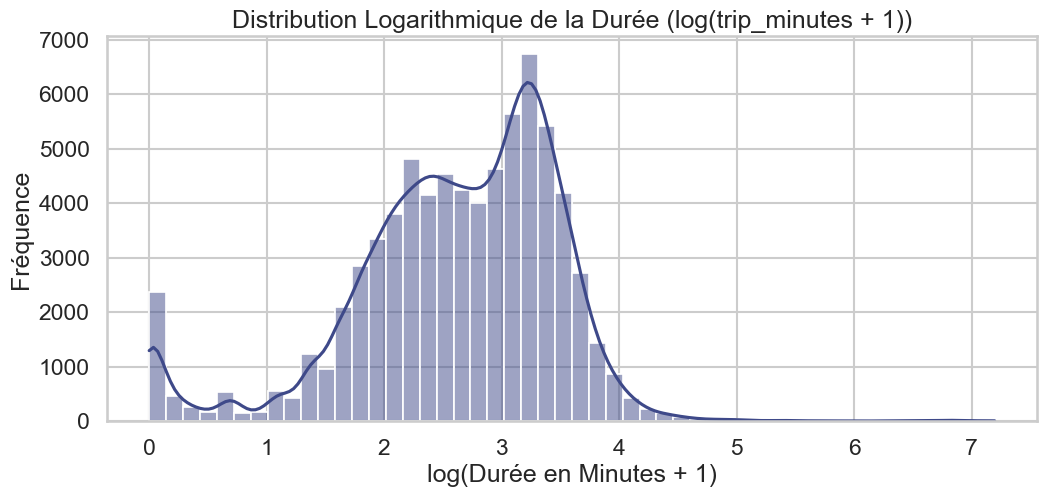

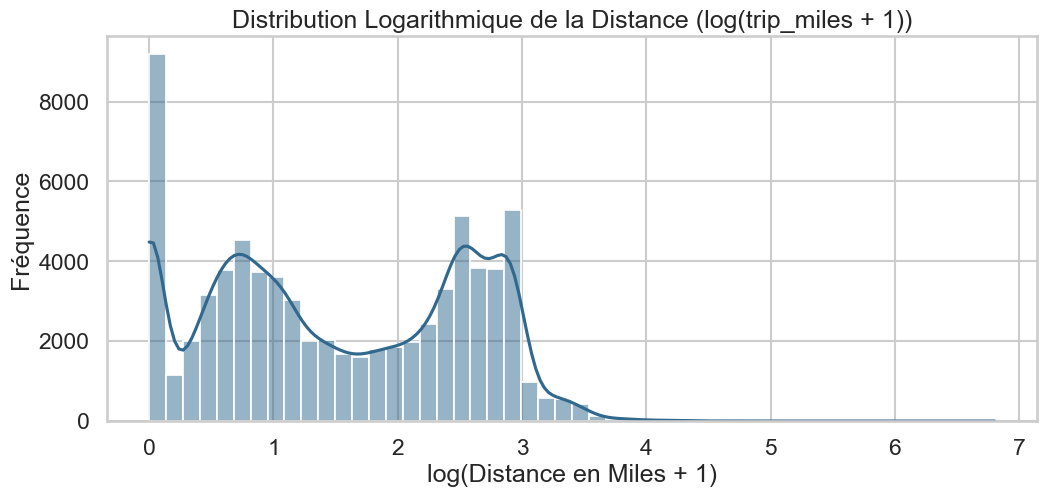

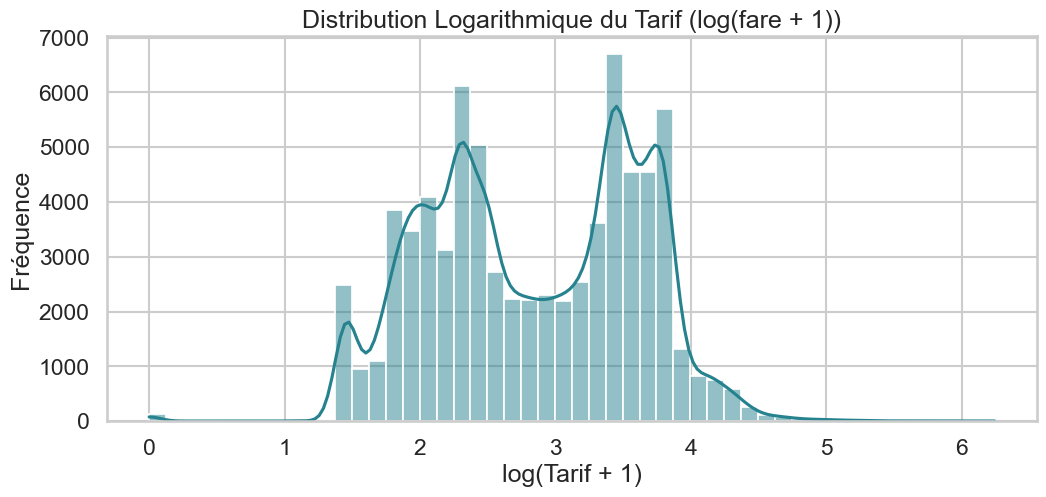

In [10]:
# Distribution Log(Durée en minutes)
if 'log_trip_minutes' in df.columns:
    plt.figure(figsize=(12, 5))
    sns.histplot(df['log_trip_minutes'].dropna(), bins=50, kde=True, color=base_palette[1])
    plt.title('Distribution Logarithmique de la Durée (log(trip_minutes + 1))')
    plt.xlabel('log(Durée en Minutes + 1)')
    plt.ylabel('Fréquence')
    plt.show()
else: print("Colonne log_trip_minutes non disponible.")

# ... (idem pour log_trip_miles et log_fare avec base_palette[2], base_palette[3])
if 'log_trip_miles' in df.columns:
    plt.figure(figsize=(12, 5))
    sns.histplot(df['log_trip_miles'].dropna(), bins=50, kde=True, color=base_palette[2])
    plt.title('Distribution Logarithmique de la Distance (log(trip_miles + 1))')
    plt.xlabel('log(Distance en Miles + 1)')
    plt.ylabel('Fréquence')
    plt.show()
else: print("Colonne log_trip_miles non disponible.")

if 'log_fare' in df.columns:
    plt.figure(figsize=(12, 5))
    sns.histplot(df['log_fare'].dropna(), bins=50, kde=True, color=base_palette[3])
    plt.title('Distribution Logarithmique du Tarif (log(fare + 1))')
    plt.xlabel('log(Tarif + 1)')
    plt.ylabel('Fréquence')
    plt.show()
else: print("Colonne log_fare non disponible.")

### 4.2 Visualisation des Distributions après Clipping IQR

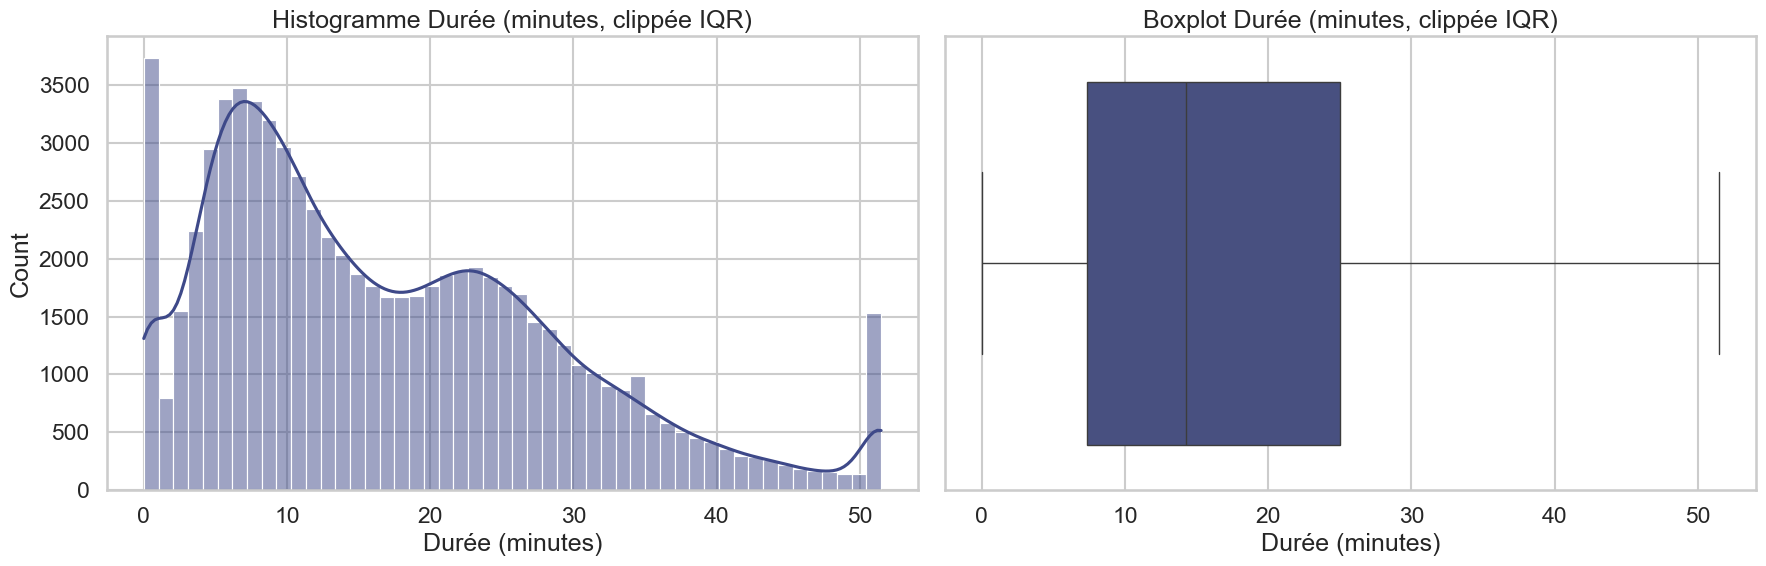

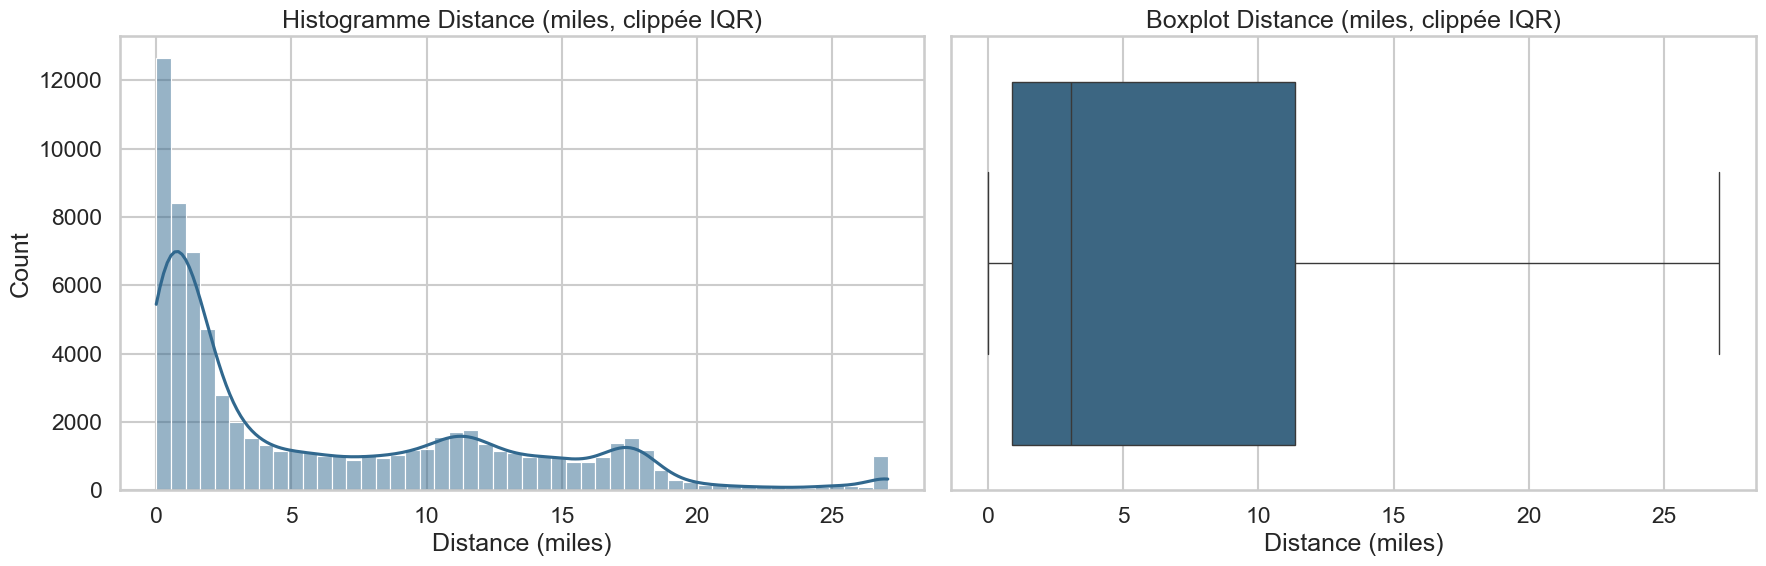

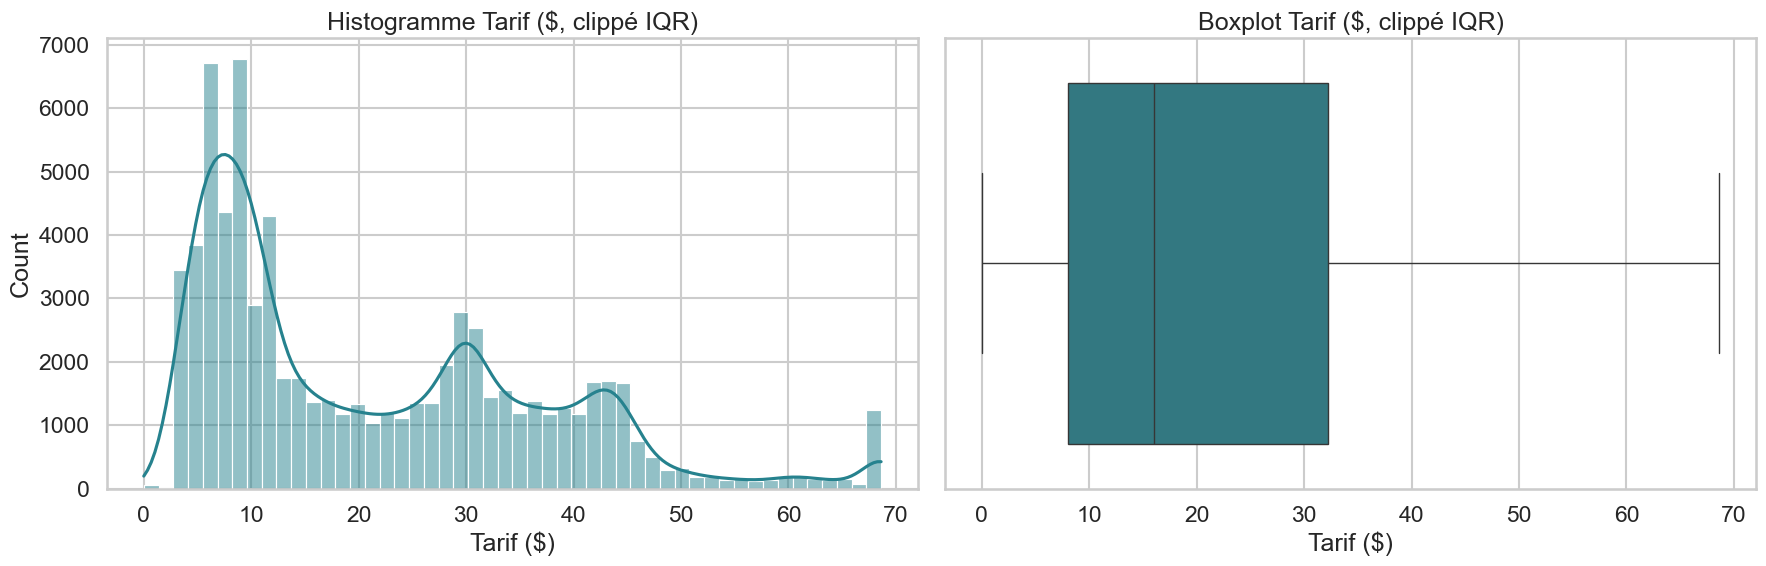

In [11]:
# Distribution de la durée (trip_minutes) avec valeurs clippées par IQR
if 'trip_minutes_iqr_capped' in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    sns.histplot(df['trip_minutes_iqr_capped'].dropna(), bins=50, kde=True, ax=axes[0], color=base_palette[1])
    axes[0].set_title("Histogramme Durée (minutes, clippée IQR)")
    axes[0].set_xlabel("Durée (minutes)")
    sns.boxplot(x=df['trip_minutes_iqr_capped'].dropna(), ax=axes[1], color=base_palette[1])
    axes[1].set_title("Boxplot Durée (minutes, clippée IQR)")
    axes[1].set_xlabel("Durée (minutes)")
    plt.tight_layout()
    plt.show()
else: print("Colonne trip_minutes_iqr_capped non disponible.")

# ... (idem pour trip_miles_iqr_capped et fare_iqr_capped avec base_palette[2], base_palette[3])
if 'trip_miles_iqr_capped' in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    sns.histplot(df['trip_miles_iqr_capped'].dropna(), bins=50, kde=True, ax=axes[0], color=base_palette[2])
    axes[0].set_title("Histogramme Distance (miles, clippée IQR)")
    axes[0].set_xlabel("Distance (miles)")
    sns.boxplot(x=df['trip_miles_iqr_capped'].dropna(), ax=axes[1], color=base_palette[2])
    axes[1].set_title("Boxplot Distance (miles, clippée IQR)")
    axes[1].set_xlabel("Distance (miles)")
    plt.tight_layout()
    plt.show()
else: print("Colonne trip_miles_iqr_capped non disponible.")

if 'fare_iqr_capped' in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    sns.histplot(df['fare_iqr_capped'].dropna(), bins=50, kde=True, ax=axes[0], color=base_palette[3])
    axes[0].set_title("Histogramme Tarif ($, clippé IQR)")
    axes[0].set_xlabel("Tarif ($)")
    sns.boxplot(x=df['fare_iqr_capped'].dropna(), ax=axes[1], color=base_palette[3])
    axes[1].set_title("Boxplot Tarif ($, clippé IQR)")
    axes[1].set_xlabel("Tarif ($)")
    plt.tight_layout()
    plt.show()
else: print("Colonne fare_iqr_capped non disponible.")

## 5. Ingénierie de Features
 Création de features temporelles. La vitesse a déjà été calculée.

In [12]:
# Création de features temporelles (déjà fait si la colonne existe)
time_cols_exist = True
time_features = ['start_hour', 'day_of_week', 'day_name', 'month', 'is_weekend']
for col in time_features:
    if col not in df.columns:
        time_cols_exist = False

if not time_cols_exist and 'trip_start_timestamp' in df.columns:
    print("\nCréation des features temporelles...")
    df['start_hour'] = df['trip_start_timestamp'].dt.hour
    df['day_of_week'] = df['trip_start_timestamp'].dt.dayofweek # Lundi=0, Dimanche=6
    df['day_name'] = df['trip_start_timestamp'].dt.day_name() # Nom du jour
    df['month'] = df['trip_start_timestamp'].dt.month
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int) # 1 si weekend, 0 sinon
    print("Nouvelles colonnes temporelles créées.")
    print(df[['trip_start_timestamp'] + time_features].head())
elif 'trip_start_timestamp' not in df.columns:
     print("\nColonne 'trip_start_timestamp' non trouvée, création de features temporelles ignorée.")
else:
     print("\nFeatures temporelles déjà créées précédemment.")


Création des features temporelles...
Nouvelles colonnes temporelles créées.
       trip_start_timestamp  start_hour  day_of_week day_name  month  \
0 2023-01-01 00:00:00+00:00           0            6   Sunday      1   
1 2023-01-01 00:00:00+00:00           0            6   Sunday      1   
2 2023-01-01 00:00:00+00:00           0            6   Sunday      1   
3 2023-01-01 00:00:00+00:00           0            6   Sunday      1   
4 2023-01-01 20:45:00+00:00          20            6   Sunday      1   

   is_weekend  
0           1  
1           1  
2           1  
3           1  
4           1  


## 6. Analyse Bivariée et Multivariée
 Exploration des relations entre variables, en utilisant les versions transformées/clippées si pertinent et en explorant les interactions.

### 6.1 Relations entre Variables Numériques Clés (Post-Traitement)

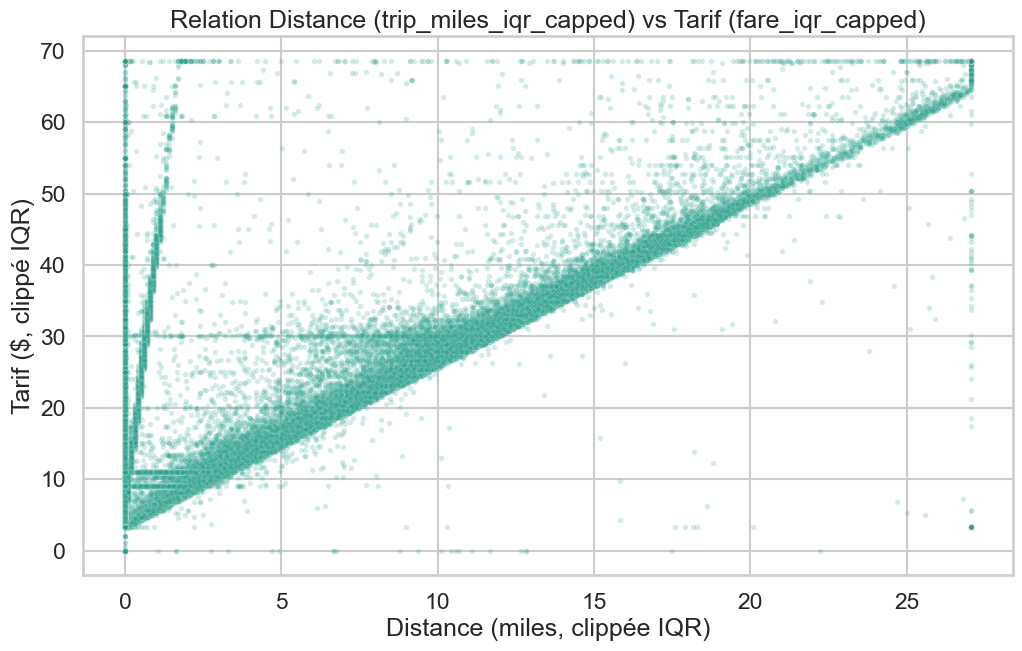

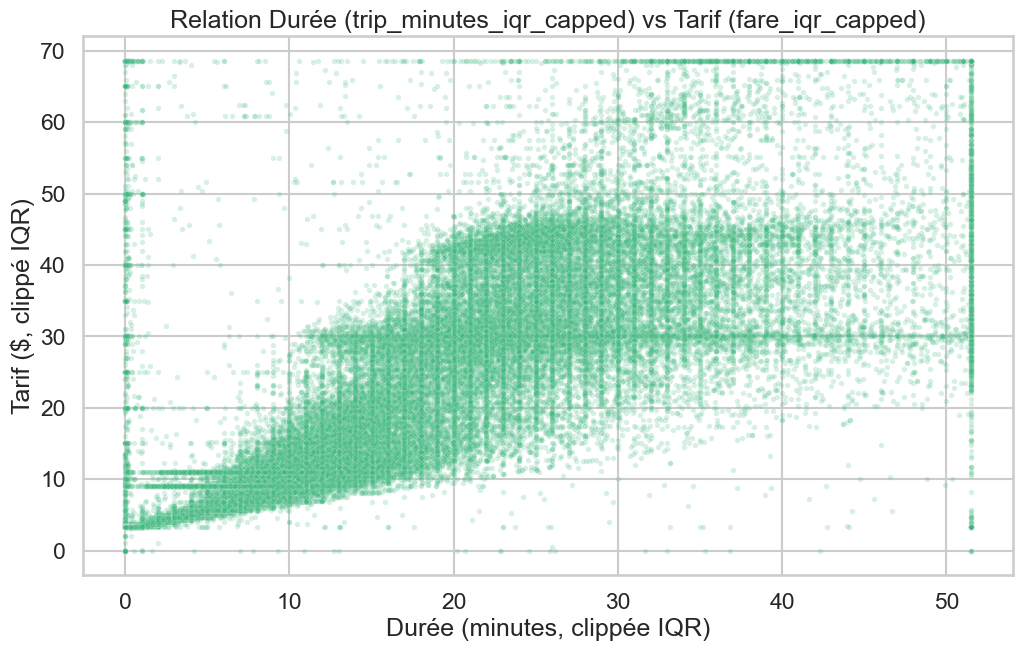

In [13]:
# Utiliser les versions clippées pour ces visualisations afin de mieux voir la tendance centrale
x_col_scatter = 'trip_miles_iqr_capped' if 'trip_miles_iqr_capped' in df.columns else None
y_col_scatter = 'fare_iqr_capped' if 'fare_iqr_capped' in df.columns else None
x_col_scatter_dur = 'trip_minutes_iqr_capped' if 'trip_minutes_iqr_capped' in df.columns else None

# Scatterplot : Distance vs Tarif (clippé)
if x_col_scatter and y_col_scatter:
    plt.figure(figsize=(12, 7))
    sns.scatterplot(data=df, x=x_col_scatter, y=y_col_scatter, alpha=0.2, s=15, color=base_palette[4])
    # Optionnel : Ajouter une ligne de régression peut être trompeur si la relation n'est pas linéaire
    # sns.regplot(data=df, x=x_col_scatter, y=y_col_scatter, scatter=False, line_kws={'color':'red', 'linewidth': 2})
    plt.title(f"Relation Distance ({x_col_scatter}) vs Tarif ({y_col_scatter})")
    plt.xlabel(f"Distance ({'miles, clippée IQR'})")
    plt.ylabel(f"Tarif ({'$, clippé IQR'})")
    plt.show()
else: print("Colonnes Distance/Tarif clippées non disponibles pour scatterplot.")

# Scatterplot : Durée vs Tarif (clippé)
if x_col_scatter_dur and y_col_scatter:
    plt.figure(figsize=(12, 7))
    sns.scatterplot(data=df, x=x_col_scatter_dur, y=y_col_scatter, alpha=0.2, s=15, color=base_palette[5])
    plt.title(f"Relation Durée ({x_col_scatter_dur}) vs Tarif ({y_col_scatter})")
    plt.xlabel(f"Durée ({'minutes, clippée IQR'})")
    plt.ylabel(f"Tarif ({'$, clippé IQR'})")
    plt.show()
else: print("Colonnes Durée/Tarif clippées non disponibles pour scatterplot.")

### 6.2 Interactions avec Variables Catégorielles

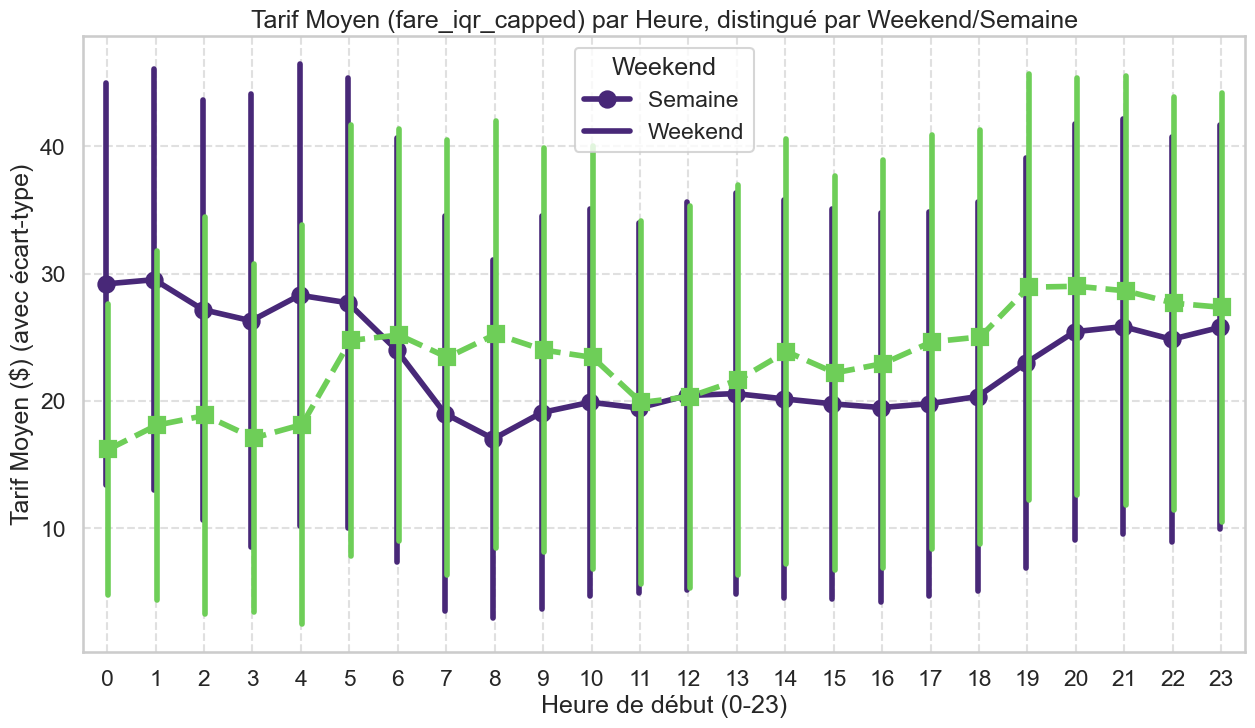

In [14]:
# Interaction Tarif vs Heure vs Weekend
# Utiliser la version clippée du tarif pour une meilleure lisibilité du plot
y_col_plot = 'fare_iqr_capped' if 'fare_iqr_capped' in df.columns else 'fare'

if 'start_hour' in df.columns and 'is_weekend' in df.columns and y_col_plot in df.columns:
    plt.figure(figsize=(15, 8))
    # Utiliser pointplot pour montrer la tendance centrale et la variabilité (intervalle de confiance)
    sns.pointplot(data=df, x='start_hour', y=y_col_plot, hue='is_weekend',
                  palette={0: base_palette[0], 1: base_palette[6]}, # 0=Weekday, 1=Weekend
                  markers=["o", "s"], linestyles=["-", "--"], dodge=True, errorbar='sd') # dodge sépare les lignes
    plt.title(f"Tarif Moyen ({y_col_plot}) par Heure, distingué par Weekend/Semaine")
    plt.xlabel("Heure de début (0-23)")
    plt.ylabel(f"Tarif Moyen ({'$' if 'fare' in y_col_plot else y_col_plot}) (avec écart-type)")
    plt.xticks(range(0, 24))
    plt.legend(title='Weekend', labels=['Semaine', 'Weekend'])
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
else:
    print("Colonnes nécessaires ('start_hour', 'is_weekend', tarif) non disponibles pour l'analyse d'interaction horaire.")

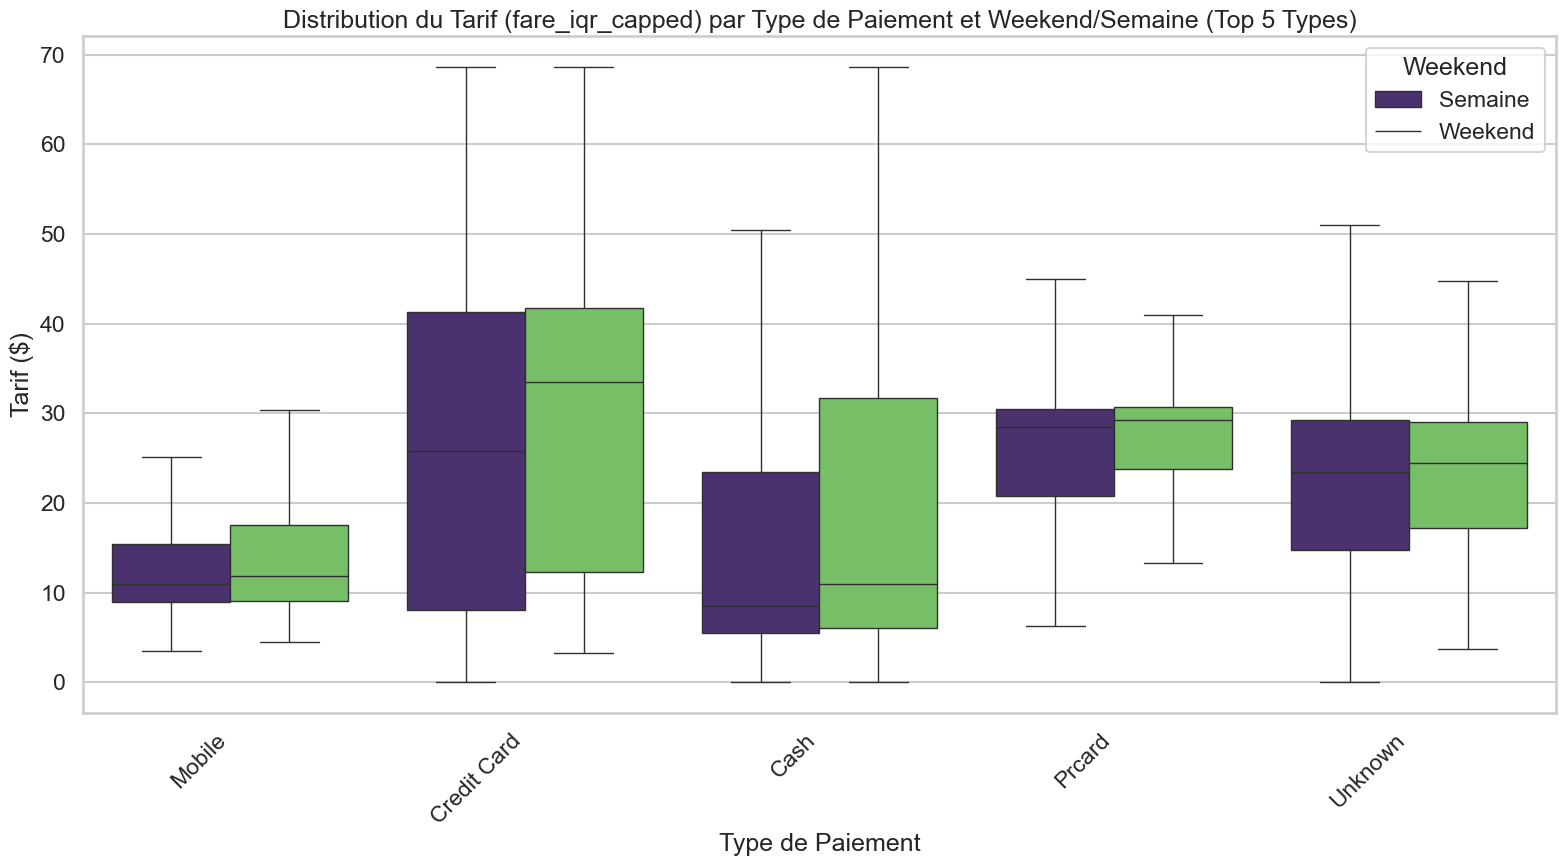

In [15]:
# Interaction Tarif vs Type de Paiement vs Weekend
if 'payment_type' in df.columns and 'is_weekend' in df.columns and y_col_plot in df.columns:
    plt.figure(figsize=(16, 9))
    # Utiliser des boxplots pour voir la distribution complète
    # Filtrer potentiellement les types de paiement rares pour la clarté
    common_payments = df['payment_type'].value_counts().nlargest(5).index
    df_filtered_payment = df[df['payment_type'].isin(common_payments)]

    sns.boxplot(data=df_filtered_payment, x='payment_type', y=y_col_plot, hue='is_weekend',
                palette={0: base_palette[0], 1: base_palette[6]}, showfliers=False) # Cacher outliers pour clarté
    plt.title(f"Distribution du Tarif ({y_col_plot}) par Type de Paiement et Weekend/Semaine (Top 5 Types)")
    plt.xlabel("Type de Paiement")
    plt.ylabel(f"Tarif ({'$' if 'fare' in y_col_plot else y_col_plot})")
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Weekend', labels=['Semaine', 'Weekend'])
    plt.tight_layout()
    plt.show()
else:
    print("Colonnes nécessaires ('payment_type', 'is_weekend', tarif) non disponibles pour l'analyse d'interaction paiement.")

### 6.3 Analyse Temporelle (Volume)

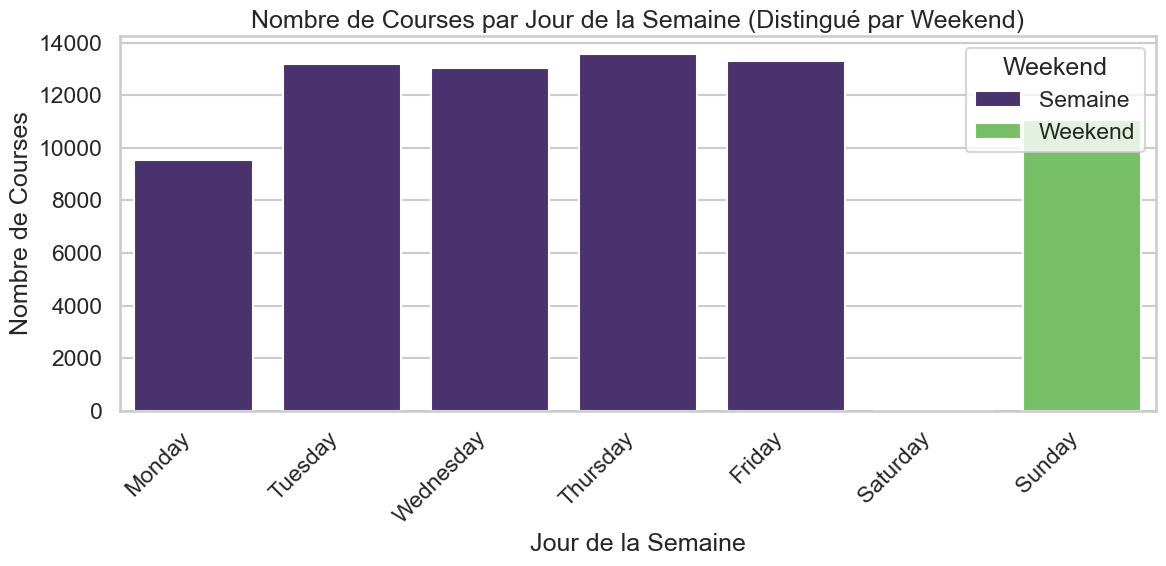

In [16]:
# Analyse temporelle : Nombre de courses par jour de la semaine (déjà fait, peut être affiné)
if 'day_name' in df.columns and 'is_weekend' in df.columns:
    plt.figure(figsize=(12, 6))
    day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    sns.countplot(data=df, x='day_name', order=day_order, hue='is_weekend', palette={0: base_palette[0], 1: base_palette[6]}, dodge=False)
    plt.title("Nombre de Courses par Jour de la Semaine (Distingué par Weekend)")
    plt.xlabel("Jour de la Semaine")
    plt.ylabel("Nombre de Courses")
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Weekend', labels=['Semaine', 'Weekend'])
    plt.tight_layout()
    plt.show()
else: print("Colonnes 'day_name' ou 'is_weekend' non disponibles.")

## 7. Analyse de Corrélation
 Matrice de corrélation mise à jour avec les variables pertinentes (incluant versions clippées).


Calcul de la corrélation sur les colonnes: ['trip_minutes_iqr_capped', 'trip_miles_iqr_capped', 'fare_iqr_capped', 'tips', 'tolls', 'extras', 'trip_total', 'start_hour', 'day_of_week', 'month', 'is_weekend']


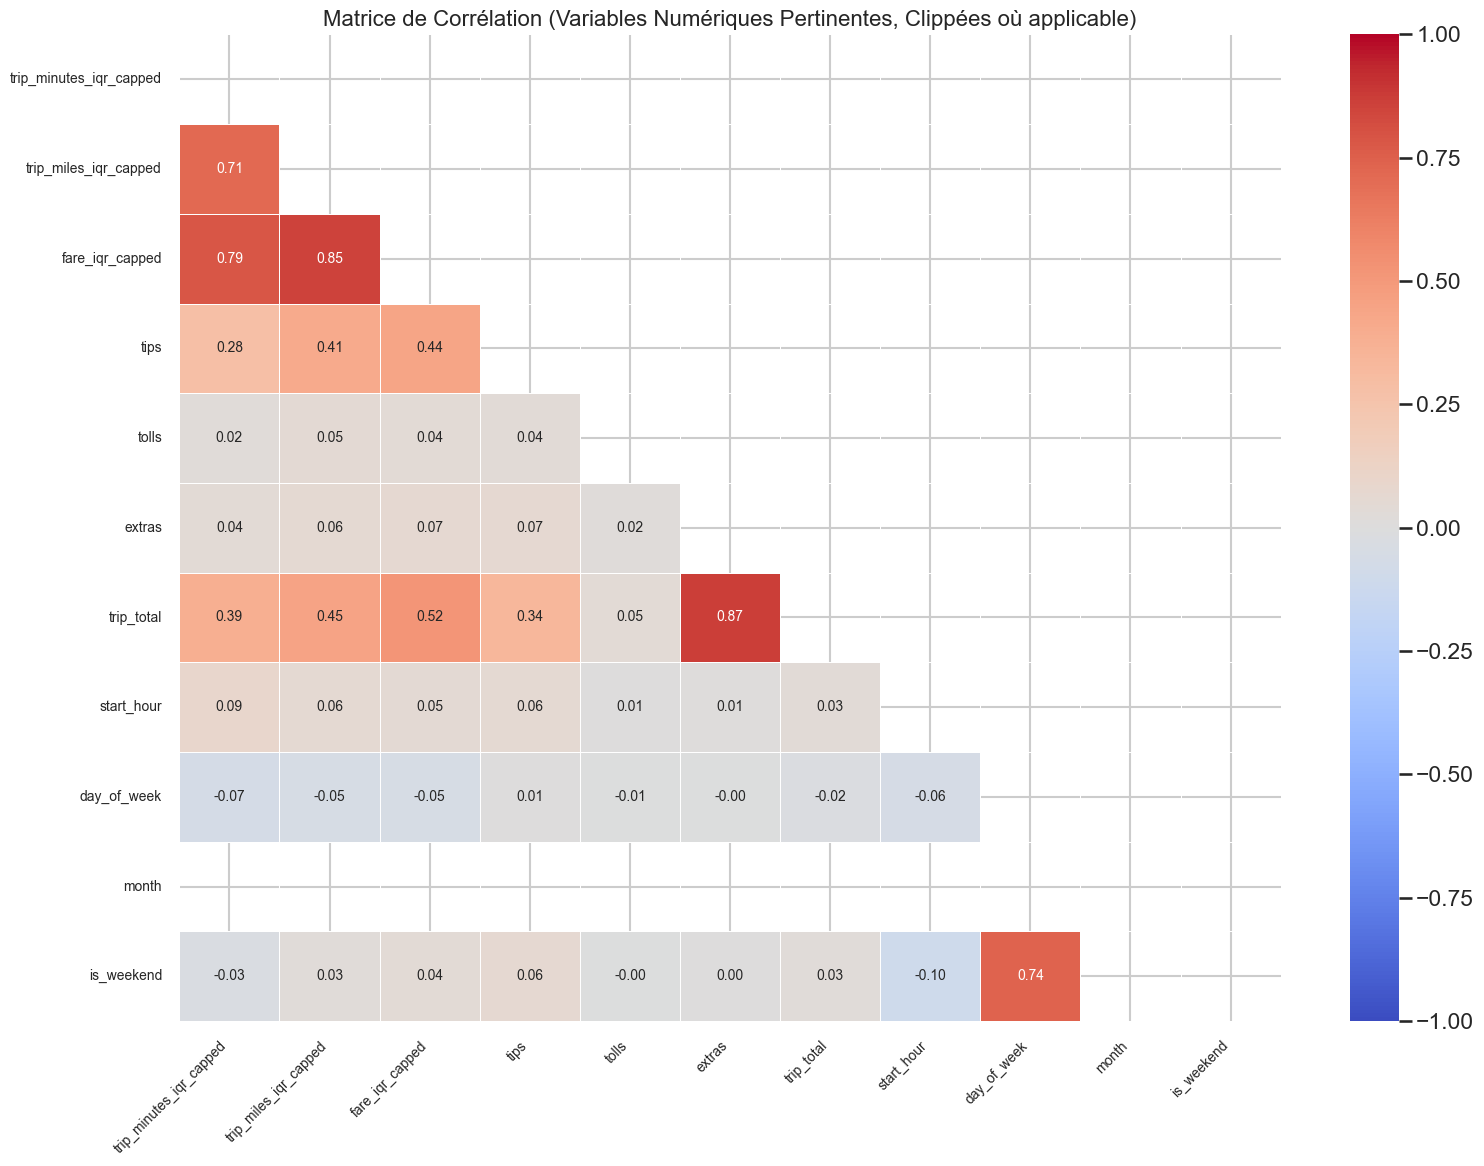

In [17]:
plt.figure(figsize=(16, 12))

# Sélection des colonnes numériques pertinentes
potential_num_cols = ['trip_minutes_iqr_capped', 'trip_miles_iqr_capped', 'fare_iqr_capped', # Versions clippées
                      'tips', 'tolls', 'extras', 'trip_total', # Autres composantes monétaires (originaux si non clippés)
                      'average_speed_mph', # Vitesse
                      'start_hour', 'day_of_week', 'month', 'is_weekend'] # Features temporelles numériques

relevant_numeric_cols = [col for col in potential_num_cols if col in df.columns and pd.api.types.is_numeric_dtype(df[col])]

if relevant_numeric_cols:
    print(f"\nCalcul de la corrélation sur les colonnes: {relevant_numeric_cols}")
    corr_matrix = df[relevant_numeric_cols].corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # Masque pour partie supérieure

    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5,
                mask=mask, annot_kws={"size": 10}, vmin=-1, vmax=1) # Assurer échelle de -1 à 1
    plt.title("Matrice de Corrélation (Variables Numériques Pertinentes, Clippées où applicable)", fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()
else:
    print("\nAucune colonne numérique pertinente trouvée pour la matrice de corrélation.")

## 8. Observations Générales et Synthèse (Révisée)

 - **Qualité des Données - Problèmes Majeurs de l'Échantillon :**
     - **Manquants :** Données de localisation quasi-totalement absentes, rendant impossible toute analyse spatiale fine *sur cet échantillon*. Manquants gérables ailleurs.
     - **Valeurs Nulles/Faibles :** Proportion *anormalement élevée* de courses avec durée, distance et/ou tarif nuls ou très faibles. Cela suggère fortement un problème avec cet échantillon (erreurs, trajets non standards majoritaires?) et nécessitera un filtrage important avant modélisation.
     - **Incohérences :** Présence d'incohérences pour les totaux, les durées (arrondis?), et la vitesse (vitesses nulles ou extrêmes), confirmant des problèmes de qualité ponctuels ou systématiques dans certaines lignes.
     - **Outliers :** Les variables numériques clés sont affectées par des outliers importants. Le clipping IQR et la transformation log ont permis de mieux visualiser les tendances centrales et de normaliser les distributions.

 - **Distributions et Relations :**
     - Forte asymétrie droite pour durée, distance, tarif confirmée.
     - Relations positives claires entre tarif, distance et durée, visibles même après clipping IQR sur la partie centrale des données.
     - Influence marquée des facteurs temporels (heure, jour, weekend) sur le volume de courses et sur les tarifs/vitesses moyennes (médianes). Des interactions existent (ex: différence de tarif weekend/semaine varie selon l'heure).

 - **Ingénierie de Features :**
     - Création de features temporelles utiles. La vitesse moyenne aide à détecter des anomalies.


## 9. Conclusion de l'Analyse Exploratoire et Prochaines Étapes (Révisées)

 Cette analyse exploratoire approfondie de *l'échantillon* Chicago Taxi Trips a mis en lumière non seulement les relations attendues mais aussi **d'importantes limitations et problèmes de qualité spécifiques à ces données** :

 1.  **Fiabilité de l'Échantillon Questionnable :** La prévalence massive de trajets à valeur nulle/faible et les données de localisation manquantes remettent en question la représentativité de cet échantillon pour modéliser des courses "normales".
 2.  **Nettoyage Drastique Requis :** Un filtrage significatif des lignes considérées comme erronées ou non pertinentes (durée/distance/tarif nuls, incohérences majeures) sera indispensable avant toute modélisation visant à prédire le tarif de courses standards.
 3.  **Stratégie d'Outliers à Définir :** Le choix entre utiliser les données clippées, transformées, ou des modèles robustes dépendra de l'impact sur la performance et de l'objectif (prédire la majorité des cas vs capturer les extrêmes).
 4.  **Potentiel Limité sans Données Complètes :** L'impossibilité d'utiliser la localisation limite fortement la richesse de l'analyse et des features potentielles (zones, trafic estimé, etc.). L'accès au dataset complet et potentiellement plus propre est crucial.

 **Prochaines Étapes Spécifiques :**

 - **Définition du Périmètre de Modélisation :** Clarifier quelles courses on cherche à modéliser. Exclure explicitement les courses jugées erronées ou non pertinentes (ex: `trip_seconds <= 0`, `trip_miles <= 0`, `fare <= 0`, incohérences majeures). Documenter ces choix de filtrage.
 - **Traitement Final des Manquants :** Imputer les valeurs manquantes restantes sur les colonnes conservées (ex: `tips`, `tolls` via médiane ou 0 selon le contexte). Supprimer les colonnes inutilisables (localisation, `company`).
 - **Gestion Finale des Outliers/Transformations :** Choisir et appliquer la stratégie retenue (clipping, transformation, ou préparation pour modèles robustes). Standardiser/normaliser les features numériques si nécessaire.
 - **Feature Selection :** Sélectionner un sous-ensemble pertinent de features pour le modèle initial.
 - ****(Crucial)** **Obtenir et Analyser le Dataset Complet :** La priorité devrait être de travailler sur le dataset complet pour vérifier si les problèmes de qualité persistent et si les données de localisation sont disponibles, afin de mener une analyse et une modélisation plus fiables et riches.
 - **Modélisation Initiale :** Entraîner un modèle de baseline (ex: Régression Linéaire sur données transformées/clippées, ou Random Forest) pour évaluer la prédictibilité du tarif avec les données nettoyées de l'échantillon (tout en gardant à l'esprit ses limitations).

 En résumé, cette EDA révèle que si des relations logiques existent, la qualité et la complétude *de cet échantillon* posent des défis majeurs qui doivent être adressés par un nettoyage ciblé et potentiellement par l'utilisation de données plus complètes.